# Self-Driving Car Engineer Nanodegree
## Project: Vehicle Detection and Tracking

In this project, the goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car.

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## Import packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Compute color histogram features

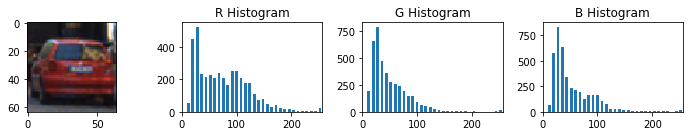

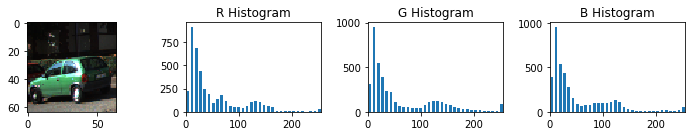

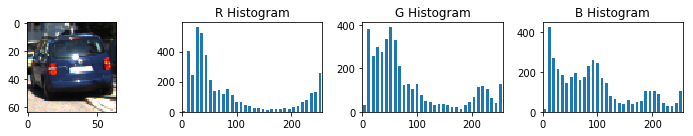

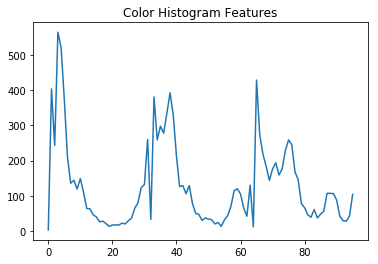

In [2]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram (img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram (img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram (img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate ((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # calc bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len (bin_edges) - 1]) / 2
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, channel1_hist, channel2_hist, channel3_hist, bin_centers

imgNames = ['226.png','269.png','2578.png']

for imgName in imgNames:
    img = cv2.imread('vehicles/KITTI_extracted/'+imgName)
    img = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
    hist_features, rh, gh, bh, bin_centers  = color_hist(img, nbins=32, bins_range=(0, 256))
    # Plot a figure with all three bar charts
    width = 5
    fig = plt.figure(figsize=(10, 2))
    plt.subplot (141)
    plt.imshow(img)
    plt.subplot (142)
    plt.bar (bin_centers, rh[0], width)
    plt.xlim (0, 256)
    plt.title ('R Histogram')
    plt.subplot (143)
    plt.bar (bin_centers, gh[0], width)
    plt.xlim (0, 256)
    plt.title ('G Histogram')
    plt.subplot (144)
    plt.bar (bin_centers, bh[0], width)
    plt.xlim (0, 256)
    plt.title ('B Histogram')
    fig.tight_layout ()
    
fig = plt.figure()
plt.plot(hist_features)
plt.title ('Color Histogram Features')

## Spacial binning

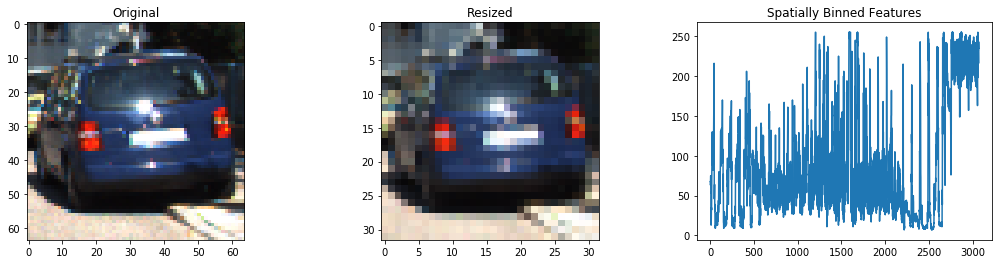

In [3]:
def bin_spatial(img, size=(32, 32)):
    resized = cv2.resize (img, size)
    features = resized.ravel ()
    return features, resized

spacial_features, resized = bin_spatial (img, size=(32, 32))

# Plot features
fig = plt.figure(figsize=(18, 4))
plt.subplot (131)
plt.imshow(img)
plt.title ('Original')
plt.subplot (132)
plt.imshow(resized)
plt.title ('Resized')
plt.subplot (133)
plt.plot (spacial_features)
plt.title ('Spatially Binned Features')

## HOG features and visualization

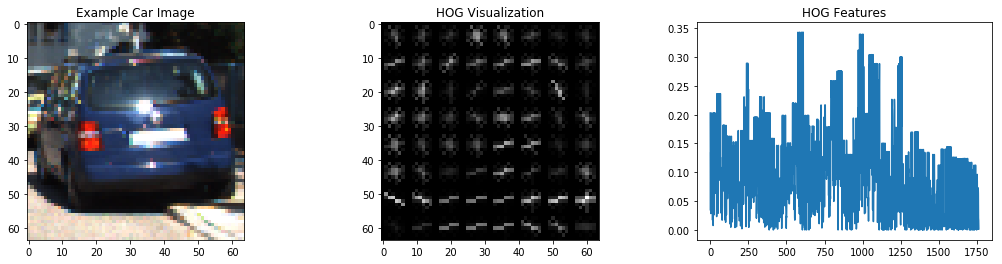

In [4]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog (img, orientations=orient,
                                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                                   cells_per_block=(cell_per_block, cell_per_block),
                                   transform_sqrt=True, block_norm='L2-Hys',
                                   visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog (img, orientations=orient,
                        pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block),
                        transform_sqrt=True, block_norm='L2-Hys',
                        visualise=vis, feature_vector=feature_vec)
        return features
    
gray = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
hog_features, hog_image = get_hog_features (gray, orient,
                                        pix_per_cell, cell_per_block,
                                        vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(18, 4))
plt.subplot (131)
plt.imshow (img)
plt.title ('Example Car Image')
plt.subplot (132)
plt.imshow (hog_image, cmap='gray')
plt.title ('HOG Visualization')
plt.subplot (133)
plt.plot (hog_features)
plt.title ('HOG Features')

## Extract features from a single image window

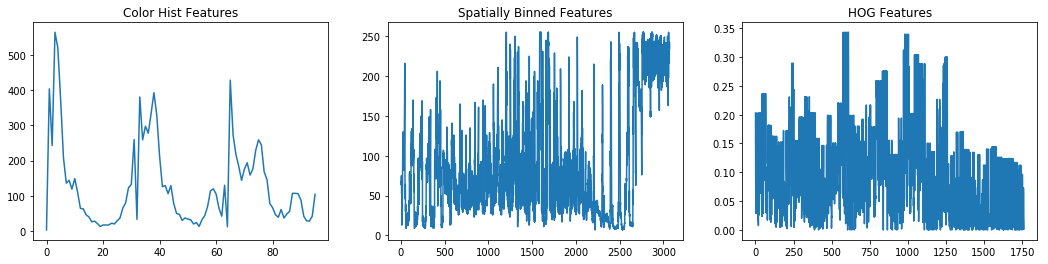

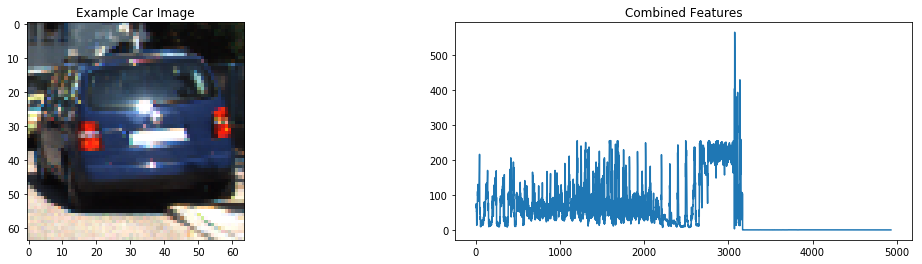

In [5]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor (img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor (img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor (img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor (img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor (img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy (img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features, _ = bin_spatial (feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append (spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features, _, _, _, _ = color_hist (feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append (hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            gray = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features (gray, orient, pix_per_cell, cell_per_block,
                                                    vis=False, feature_vec=True)
        else:
            hog_features = get_hog_features (feature_image[:, :, hog_channel], orient,
                                             pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append (hog_features)

    # 9) Return concatenated array of features
    return np.concatenate (img_features)


combined_features = single_img_features (img, hog_channel='ALL')

# Plot the examples
# Plot features
fig = plt.figure(figsize=(18, 4))
plt.subplot (131)
plt.plot (hist_features)
plt.title ('Color Hist Features')
plt.subplot (132)
plt.plot (spacial_features)
plt.title ('Spatially Binned Features')
plt.subplot (133)
plt.plot (hog_features)
plt.title ('HOG Features')
fig.savefig('output_images/all_features.png')

fig = plt.figure(figsize=(18, 4))
plt.subplot (121)
plt.imshow (img)
plt.title ('Example Car Image')
plt.subplot (122)
plt.plot (combined_features)
plt.title ('Combined Features')
fig.savefig('output_images/combined_features.png')

## Extract features from a list of images

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread (file)
        img = cv2.imread(file)
        img = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)

        file_features= single_img_features(img, color_space, spatial_size,
                        hist_bins, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)

        features.append (file_features)
    # Return list of feature vectors
    return features

## Combine features

In [7]:
def get_features(cars, notcars, color_space = 'RGB', spatial_size = (32, 32), hist_bins = 32,
                 orient = 9, pix_per_cell = 8, cell_per_block = 2, 
                 hog_channel = "ALL", spatial_feat = True, 
                 hist_feat = True, hog_feat = True):
    
    print('- extract car features')
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    print('- extract not car features')   
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    return car_features, notcar_features

## Read file names

In [8]:
import glob

cars = glob.glob ('vehicles/*/*.png')
notcars = glob.glob ('non-vehicles/*/*.png')

print('cars:    ', len(cars))
print('not cars:', len(notcars))

cars:     8792
not cars: 8968


## Combine and normalize features

In [9]:
# parameters
color_space = 'RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9           # HOG orientations
pix_per_cell = 8     # HOG pixels per cell
cell_per_block = 2   # HOG cells per block
hog_channel = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32       # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True     # Histogram features on or off
hog_feat = True      # HOG features on or off

# Reduce the sample size for tests
#sample_size = 1000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

print('extract features')
car_features, notcar_features = get_features(cars, notcars, color_space=color_space,
                                             spatial_size=spatial_size, hist_bins=hist_bins,
                                             orient=orient, pix_per_cell=pix_per_cell,
                                             cell_per_block=cell_per_block,
                                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                                             hist_feat=hist_feat, hog_feat=hog_feat)

extract features
- extract car features
- extract not car features


## normalize features

normalize features


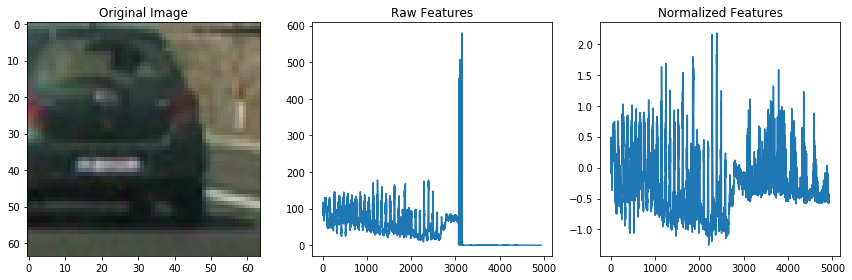

In [10]:
from sklearn.preprocessing import StandardScaler

print('normalize features')

# Create an array stack of feature vectors
X = np.vstack ((car_features, notcar_features)).astype (np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit (X)
# Apply the scaler to X
scaled_X = X_scaler.transform (X)

# Plot an example of raw and scaled features
car_ind = np.random.randint (0, len (cars))
fig = plt.figure (figsize=(12, 4))
plt.subplot (131)
plt.imshow (mpimg.imread (cars[car_ind]))
plt.title ('Original Image')
plt.subplot (132)
plt.plot (X[car_ind])
plt.title ('Raw Features')
plt.subplot (133)
plt.plot (scaled_X[car_ind])
plt.title ('Normalized Features')
fig.tight_layout ()
fig.savefig('output_images/normalized_features.png')

## Train the classifier

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time

# Define the labels vector
y = np.hstack ((np.ones (len (car_features)), np.zeros (len (notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint (0, 100)
X_train, X_test, y_train, y_test = train_test_split (scaled_X, y, test_size=0.2, random_state=rand_state)

print ('Using:', orient, 'orientations', pix_per_cell,
       'pixels per cell and', cell_per_block, 'cells per block')
print ('Feature vector length:', len (X_train[0]))
# Use a linear SVC
svc = LinearSVC ()
# Check the training time for the SVC
t = time.time ()
svc.fit (X_train, y_train)
t2 = time.time ()
print (round (t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print ('Test Accuracy of SVC = ', round (svc.score (X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time ()

C:\Users\Frank\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
17.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9817


## Sliding Windows

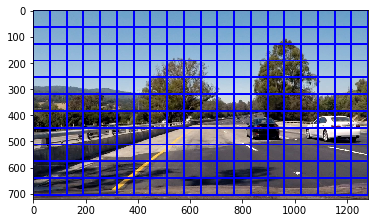

In [13]:
image = mpimg.imread ('test_images/test4.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy (img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle (imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int (xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int (xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int (xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int (xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int ((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int ((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range (ny_windows):
        for xs in range (nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append (((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


windows = slide_window (image, x_start_stop=[None, None], y_start_stop=[None, None],
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes (image, windows, color=(0, 0, 255), thick=6)
plt.imshow (window_img)

## Search Windows

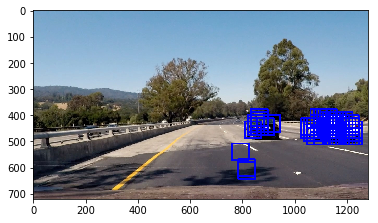

In [14]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize (img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features (test_img, color_space=color_space,
                                        spatial_size=spatial_size, hist_bins=hist_bins,
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform (np.array (features).reshape (1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict (test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append (window)
    # 8) Return windows for positive detections
    return on_windows

draw_image = np.copy (image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

x_start_stop = [760, 1260]
y_start_stop = [340, 680] # Min and max in y to search in slide_window()
xy_window = (64,64)
xy_overlap = (0.8, 0.8)

windows = slide_window (image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                        xy_window=xy_window, xy_overlap=xy_overlap)

hot_windows = search_windows (image, windows, svc, X_scaler, color_space=color_space,
                              spatial_size=spatial_size, hist_bins=hist_bins,
                              orient=orient, pix_per_cell=pix_per_cell,
                              cell_per_block=cell_per_block,
                              hog_channel=hog_channel, spatial_feat=spatial_feat,
                              hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes (draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow (window_img)

## Create Heat Map
avoid multiple detections and false positives

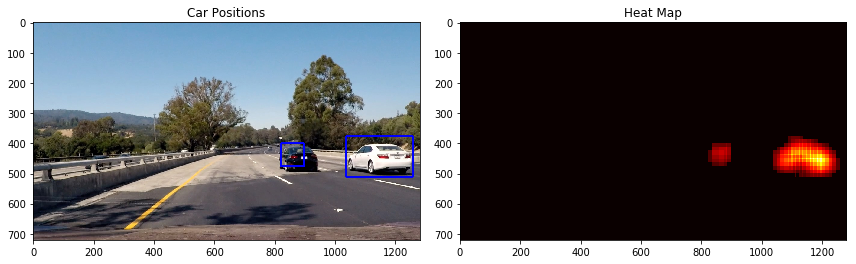

In [18]:
from scipy.ndimage.measurements import label

heat = np.zeros_like (image[:, :, 0]).astype (np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range (1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero ()
        # Identify x and y values of those pixels
        nonzeroy = np.array (nonzero[0])
        nonzerox = np.array (nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min (nonzerox), np.min (nonzeroy)), (np.max (nonzerox), np.max (nonzeroy)))
        # Draw the box on the image
        cv2.rectangle (img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat (heat, hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold (heat, 2)

# Visualize the heatmap when displaying
heatmap = np.clip (heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label (heatmap)
draw_img = draw_labeled_bboxes (np.copy (image), labels)

fig = plt.figure (figsize=(12, 4))
plt.subplot (121)
plt.imshow (draw_img)
plt.title ('Car Positions')
plt.subplot (122)
plt.imshow (heatmap, cmap='hot')
plt.title ('Heat Map')
fig.tight_layout ()

## Pipeline for video processing

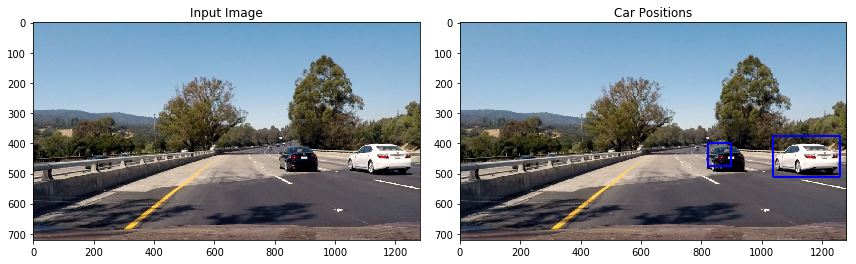

In [20]:
def pipeline(image):

    draw_image = np.copy (image)
    windows = slide_window (image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                            xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows (image, windows, svc, X_scaler, color_space=color_space,
                                  spatial_size=spatial_size, hist_bins=hist_bins,
                                  orient=orient, pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block,
                                  hog_channel=hog_channel, spatial_feat=spatial_feat,
                                  hist_feat=hist_feat, hog_feat=hog_feat)
    
    heat = np.zeros_like (image[:, :, 0]).astype (np.float)
    # Add heat to each box in box list
    heat = add_heat (heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold (heat, 2)

    # Visualize the heatmap when displaying
    heatmap = np.clip (heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label (heatmap)
    draw_img = draw_labeled_bboxes (np.copy (image), labels)
    
    return draw_img

draw_img = pipeline(image)

fig = plt.figure (figsize=(12, 4))
plt.subplot (121)
plt.imshow (image)
plt.title ('Input Image')
plt.subplot (122)
plt.imshow (draw_img)
plt.title ('Car Positions')
fig.tight_layout ()

## Video processing

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# video processing
clip = VideoFileClip("project_video.mp4")
processed_clip = clip.fl_image(pipeline)
output_file_name = 'project_video_processed.mp4'
%time processed_clip.write_videofile(output_file_name, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 1088/1261 [58:33<09:16,  3.22s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file_name))